In [0]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# 1. Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# 2. Load a file by ID and create local file.
downloaded = drive.CreateFile({'id':'1os1T4eWQfmGNkCI8z4Fx3lJ39dWcsG4l'}) # replace fileid with Id of file you want to access
downloaded.GetContentFile('data\train.csv') # now you can use train.csv 
downloaded = drive.CreateFile({'id':'1fYwpjp6hsbvmvqagCCpa63Iqoil-Dgzq'}) # replace fileid with Id of file you want to access
downloaded.GetContentFile('data\test.csv') # now you can use train.csv 

downloaded = drive.CreateFile({'id':'1UhEqap5CLhzlZTGjaXlUFMIp3q0Ux7-Z'}) # replace fileid with Id of file you want to access
downloaded.GetContentFile('data\glove.6B.50d.txt') # now you can use glove.txt



In [2]:
import pandas as pd, numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from __future__ import print_function
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import re
import sys, os, csv, codecs
from IPython.core.display import display, HTML
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation
from keras.layers import Bidirectional, GlobalMaxPool1D
from keras.models import Model
from keras import initializers, regularizers, constraints, optimizers, layers
from keras.models import Sequential


toxictrain = pd.read_csv('data\train.csv')
toxictest = pd.read_csv('data\test.csv')
EMBEDDING_PATH = "data\glove.6B.50d.txt"

toxictrain.head()
train_toxic = toxictrain.drop(['id', 'comment_text'],axis=1)
count = []
category = list(train_toxic.columns.values)
for i in category:
  count.append((i,train_toxic[i].sum()))
train_stats = pd.DataFrame(count,columns=['category','number_of_comments'])
train_stats

Using TensorFlow backend.


,category,number_of_comments
0,toxic,15294
1,severe_toxic,1595
2,obscene,8449
3,threat,478
4,insult,7877
5,identity_hate,1405


In [3]:
print("Segragate data categorywise")
target = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
toxictrain['none'] = 1-toxictrain[target].max(axis=1)
toxictrain.describe()

Segragate data categorywise


,toxic,severe_toxic,obscene,threat,insult,identity_hate,none
count,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000
mean,0.095844,0.009996,0.052948,0.002996,0.049364,0.008805,0.898321
std,0.294379,0.099477,0.223931,0.054650,0.216627,0.093420,0.302226
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


Plotting category-wise graph


Text(0.5,0,'category')

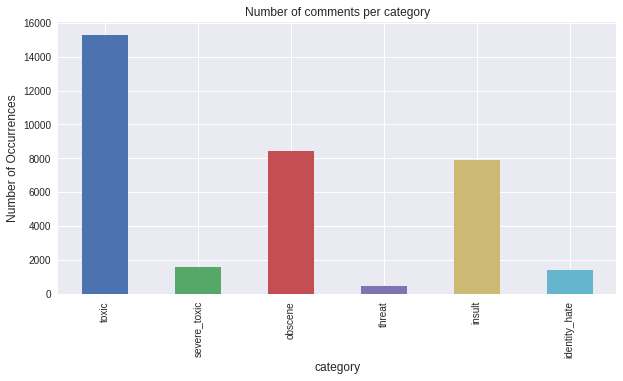

In [4]:
#number of comments category wise
print("Plotting category-wise graph")
train_stats.plot(x='category', y='number_of_comments', kind='bar', legend=False, grid=True, figsize=(10, 5))
plt.title("Number of comments per category")
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('category', fontsize=12)

In [5]:
print("Checking data")
y_train = toxictrain[target].values
x_train = toxictrain["comment_text"]
x_test  = toxictest["comment_text"]

# Sample from dataset
for j in range(5):
    print('Comment #{}:  {}'.format(j + 1, x_train[j]))
    print('Label #{}:    {}'.format(j + 1, y_train[j]))

Checking data
Comment #1:  Explanation
Why the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27
Label #1:    [0 0 0 0 0 0]
Comment #2:  D'aww! He matches this background colour I'm seemingly stuck with. Thanks.  (talk) 21:51, January 11, 2016 (UTC)
Label #2:    [0 0 0 0 0 0]
Comment #3:  Hey man, I'm really not trying to edit war. It's just that this guy is constantly removing relevant information and talking to me through edits instead of my talk page. He seems to care more about the formatting than the actual info.
Label #3:    [0 0 0 0 0 0]
Comment #4:  "
More
I can't make any real suggestions on improvement - I wondered if the section statistics should be later on, or a subsection of ""types of accidents""  -I think the references may need tidying so that they are all in the exact same for

In [6]:
print("Sorting data on word basis")
#Train data
!pip install -U -q tqdm
# Explore vocabulary
print("Defining vocabulary")
import collections
from tqdm import tqdm

# Create a counter object for each dataset
word_counter = collections.Counter([word for sentence in tqdm(x_train, total=len(x_train)) \
                                                              for word in sentence.split()])

print('{} words.'.format(len([word for sentence in x_train for word in sentence.split()])))
print('{} unique words.'.format(len(word_counter)))
print('10 Most common words in the dataset:')
print('"' + '" "'.join(list(zip(*word_counter.most_common(10)))[0]) + '"')

Sorting data on word basis
Defining vocabulary


100%|██████████| 159571/159571 [00:01<00:00, 85555.74it/s]


10734904 words.
532299 unique words.
10 Most common words in the dataset:
"the" "to" "of" "and" "a" "I" "is" "you" "that" "in"


In [7]:
#Preprocessing of data
# Tokenize and Pad
print("Preprocess the data and tokenize it")
print("Create tokenizer")
# Create tokenizer
tokenizer = Tokenizer(num_words=None,
                      filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n',
                      lower=True,
                      split=" ",
                      char_level=False)

print("Fit and run the tokenizer")
# Fit and run tokenizer
tokenizer.fit_on_texts(list(x_train))
#Transforms each text in texts in a sequence of integers
tokenized_train = tokenizer.texts_to_sequences(x_train)
tokenized_test = tokenizer.texts_to_sequences(x_test)
#word indexing it
word_index = tokenizer.word_index

# Extract variables
vocabsize = len(word_index)
print('Vocabulary size: {}'.format(vocabsize))

maxlen = max(len(seq) for seq in tokenized_train)
print("Longest comment size will be: {}".format(maxlen))

average = np.mean([len(seq) for seq in tokenized_train])
print("Average comment size: {}".format(average))

stdeviation = np.std([len(seq) for seq in tokenized_train])
print("Standard deviation of comment size: {}".format(stdeviation))

max_length = int(average + stdeviation * 3)
print('Maximum comment size: {}'.format(max_length))



Preprocess the data and tokenize it
Create tokenizer
Fit and run the tokenizer
Vocabulary size: 210337
Longest comment size will be: 1403
Average comment size: 68.22156908210138
Standard deviation of comment size: 101.07344657013672
Maximum comment size: 371


In [8]:
# Pad sequences
print("Padding the sequences")
processed_X_train = pad_sequences(tokenized_train, maxlen=max_length, padding='post', truncating='post')
processed_X_test = pad_sequences(tokenized_test, maxlen=max_length, padding='post', truncating='post')

print("Sample Tokenized data:-")
# Sample tokenization
for i, (inp, out) in enumerate(zip(x_train[:5], tokenized_train[:5])):
    print('Sequence {}'.format(i + 1))
    print('  Input:  {}'.format(inp))
    print('  Output: {}'.format(out))

Padding the sequences
Sample Tokenized data:-
Sequence 1
  Input:  Explanation
Why the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27
  Output: [688, 75, 1, 126, 130, 177, 29, 672, 4511, 12052, 1116, 86, 331, 51, 2278, 11448, 50, 6864, 15, 60, 2756, 148, 7, 2937, 34, 117, 1221, 15190, 2825, 4, 45, 59, 244, 1, 365, 31, 1, 38, 27, 143, 73, 3462, 89, 3085, 4583, 2273, 985]
Sequence 2
  Input:  D'aww! He matches this background colour I'm seemingly stuck with. Thanks.  (talk) 21:51, January 11, 2016 (UTC)
  Output: [96145, 52, 2635, 13, 555, 3809, 73, 4556, 2706, 21, 94, 38, 803, 2679, 992, 589, 8377, 182]
Sequence 3
  Input:  Hey man, I'm really not trying to edit war. It's just that this guy is constantly removing relevant information and talking to me through edits instead of my talk page. He

In [9]:
#embedding
print("Embedding the data")
embeddingindex = dict()
f = open(EMBEDDING_PATH)
for l in f:
    values = l.split()
    word = values[0]
    coeff = np.asarray(values[1:], dtype='float32')
    embeddingindex[word] = coeff
f.close()
print('Loaded %s word vectors.' % len(embeddingindex))

Embedding the data
Loaded 400000 word vectors.


In [0]:
#token = Tokenizer()
tokenizer.fit_on_texts(toxictrain['comment_text'])
#vocab_size = len(tokenizer.word_index) + 1

commontext_token = tokenizer.texts_to_sequences(toxictrain['comment_text'])
#max_length = 371
padded_seq = pad_sequences(commontext_token, maxlen=max_length, padding='post')

# Test Data
test_encoded_docs = tokenizer.texts_to_sequences(toxictest['comment_text'])
test_padded_docs = pad_sequences(test_encoded_docs, maxlen=max_length, padding='post')
# create a weight matrix for words in training
embeddingmatrix = np.zeros((vocabsize+1, 50))
for word, i in tokenizer.word_index.items():
    embeddingvector = embeddingindex.get(word)
    if embeddingvector is not None:
        embeddingmatrix[i] = embeddingvector

In [11]:
print(vocabsize)

210337


In [12]:
print("Fit the Deep Learning Model - LSTM(Long Short Term Memory) ")

model = Sequential()
print("Emedding layer - layer will output word vectors for each one of the words in senctence")
model.add(Embedding(vocabsize+1, 
                    50, weights=[embeddingmatrix], 
                    input_length=371, 
                    trainable=False))

model.add(Bidirectional(LSTM(units=50, return_sequences=False, dropout=0.1, recurrent_dropout=0.1)))
model.add(Dense(50, activation="relu"))
model.add(Dropout(0.1))
model.add(Dense(6, activation='sigmoid'))

optimizer = optimizers.Adam(lr=0.001)
model.compile(loss='binary_crossentropy',
            optimizer=optimizer,
            metrics=['accuracy'])

Fit the Deep Learning Model - LSTM(Long Short Term Memory) 
Emedding layer - layer will output word vectors for each one of the words in senctence


In [13]:
model.summary()
labels = toxictrain[target].values
print(toxictrain["comment_text"][5])
print(labels[5])
model.fit(padded_seq, labels, epochs=2, batch_size=32)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 371, 50)           10516900  
_________________________________________________________________
bidirectional_1 (Bidirection (None, 100)               40400     
_________________________________________________________________
dense_1 (Dense)              (None, 50)                5050      
_________________________________________________________________
dropout_1 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 6)                 306       
Total params: 10,562,656
Trainable params: 45,756
Non-trainable params: 10,516,900
_________________________________________________________________
"

Congratulations from me as well, use the tools well.  · talk "
[0 0 0 0 0 0]
Epoch 1/2
  2624/159571 [....................

159571/159571 [==============================] - 2367s 15ms/step - loss: 0.0744 - acc: 0.9747


Epoch 2/2
159552/159571 [============================>.] - ETA: 0s - loss: 0.0576 - acc: 0.9796

159571/159571 [==============================] - 2365s 15ms/step - loss: 0.0576 - acc: 0.9796


In [14]:
print("Predicting the model")
predictions = model.predict(padded_seq, verbose=0)


def  toxiclevel(string):
   
    # Return toxicity probability based on input string.
    # Lets Process string
    str1 = [string]
    str1 = tokenizer.texts_to_sequences(str1)
    str1 = pad_sequences(str1, maxlen=max_length, padding='post', truncating='post')
    
    # Lets Predict
    predictmat = model.predict(str1)
    
    # Print output to check toxicity levels
    print("Toxicity levels for '{}':".format(string))
    print('Toxic:         {:.0%}'.format(predictmat[0][0]))
    print('Severe Toxic:  {:.0%}'.format(predictmat[0][1]))
    print('Obscene:       {:.0%}'.format(predictmat[0][2]))
    print('Threat:        {:.0%}'.format(predictmat[0][3]))
    print('Insult:        {:.0%}'.format(predictmat[0][4]))
    print('Identity Hate: {:.0%}'.format(predictmat[0][5]))
    print()
    
    return

toxiclevel('Why the fuck are you here?')
toxiclevel('i will fight against you')
toxiclevel('have a nice day')
toxiclevel('fuck off!!')
toxiclevel('go to hell')


Predicting the model
Toxicity levels for 'Why the fuck are you here?':
Toxic:         99%
Severe Toxic:  32%
Obscene:       97%
Threat:        4%
Insult:        81%
Identity Hate: 8%

Toxicity levels for 'i will fight against you':
Toxic:         31%
Severe Toxic:  0%
Obscene:       8%
Threat:        2%
Insult:        12%
Identity Hate: 1%

Toxicity levels for 'have a nice day':
Toxic:         5%
Severe Toxic:  0%
Obscene:       2%
Threat:        0%
Insult:        2%
Identity Hate: 0%

Toxicity levels for 'fuck off!!':
Toxic:         98%
Severe Toxic:  36%
Obscene:       96%
Threat:        4%
Insult:        75%
Identity Hate: 7%

Toxicity levels for 'go to hell':
Toxic:         77%
Severe Toxic:  4%
Obscene:       44%
Threat:        4%
Insult:        41%
Identity Hate: 4%



In [15]:
toxiclevel('What is your name')


Toxicity levels for 'What is your name':
Toxic:         5%
Severe Toxic:  0%
Obscene:       1%
Threat:        0%
Insult:        1%
Identity Hate: 0%

